In [2]:
#!pip install ipympl

In [3]:
import numpy as np
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget

import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.signal import firwin
import matplotlib.patches as patches
from scipy.io import savemat
from tqdm import tqdm
from scipy.interpolate import CubicSpline

# Functions

In [4]:
def IQ_LUT(const):
    mapping_table_QAM16 = {
        (0,0,0,0) : -3-3j,
        (0,0,0,1) : -3-1j,
        (0,0,1,0) : -3+3j,
        (0,0,1,1) : -3+1j,
        (0,1,0,0) : -1-3j,
        (0,1,0,1) : -1-1j,
        (0,1,1,0) : -1+3j,
        (0,1,1,1) : -1+1j,
        (1,0,0,0) :  3-3j,
        (1,0,0,1) :  3-1j,
        (1,0,1,0) :  3+3j,
        (1,0,1,1) :  3+1j,
        (1,1,0,0) :  1-3j,
        (1,1,0,1) :  1-1j,
        (1,1,1,0) :  1+3j,
        (1,1,1,1) :  1+1j
    }
    demapping_table_QAM16 = {v : k for k, v in mapping_table_QAM16.items()}

    if const=='16QAM':
        mapping_table = mapping_table_QAM16
        demapping_table = demapping_table_QAM16

    return mapping_table, demapping_table

In [5]:
mapping_table, demapping_table = IQ_LUT('16QAM')

In [6]:
def SP(bits, rows, columns):
    # bits - signal to S/P
    # rows - num of subcarriers
    # columns - bits in IQ symbol

    return bits.reshape((rows, columns))

In [7]:
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])

In [8]:
def OFDM_symbol(QAM_payload, K, N, Nfft):
    # QAM_payload - mapped data
    # Nfft - total amount of subcarriers
    # K - amount of data-subcarriers
    # N - total number of OFDM symbols transmitted

    symbols = np.zeros((Nfft,N), dtype=complex) # matrix [Nfft,N]
    data=QAM_payload.reshape((K,N))

    start = Nfft//2-K//2
    symbols[start:start+K,:] = data
    return symbols

In [9]:
def IDFT(OFDM_data,Nfft,N):
    OFDM_data2 = np.fft.ifftshift(OFDM_data,0)
    return np.fft.ifftn(OFDM_data2,[Nfft,N])

In [10]:
def power_set(signal, Sig_pow_dB):
    Sig_pow = 10**(Sig_pow_dB/10)
    power=np.mean(np.abs(signal)**2) # current mean power of the signal
    amp_factor = np.sqrt(Sig_pow/power)
    signal = amp_factor*signal
    return signal

In [11]:
def channel(signal,noise_dB):
    signal_power = np.mean(np.abs(signal)**2)
    sigma2=10**(noise_dB/10)
    SNRdB = 10*np.log10(signal_power/sigma2)
    # print('SNR for given noise and signal power: %.4f Signal power in dB: %.4f' % (SNRdB, 10*np.log10(signal_power)))

    # Generate noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*signal.shape)+1j*np.random.randn(*signal.shape))
    noise_power = 10*np.log10(np.mean(np.abs(noise)**2))
    print('Noise power in dB: %.2f' % (noise_power))

    return noise, noise + signal

In [12]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)

In [13]:
def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])

    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))

    # for each element in QAM, choose the index in constellation
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)

    # get back the real constellation point
    hardDecision = constellation[const_index]

    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

In [14]:
def PS(bits):
    return bits.reshape((-1,))

# OFDM generator

## Parameters setting

In [15]:
Fc1 = 20e3 # in kHz n25 band carrier frequency
Fc2 = 20e3 # in kHz n66 band carrier frequency

K = 64 # number of used OFDM subcarriers
df = 2*5*1e3/K # scs in kHz, 2*Occupied_bandwidth[Mhz]*1e3/Subcarrier_num
Nfft = int(2048*2)

B = df*int(Nfft/2) #  bandwidth in kHz
print("Current Bandwidth: in kHz", B)
print("Current Occupied Bandwidth: in kHz", df*int(K/2))
Fs = B         # sampling frequency
N = 1000           # number of OFDM symbols transmitted

### Power
Sig_pow_dB = 90 # signal power in dB
noise_dB = 50  # noise power

### Carrier arrangement
# allCarriers = np.arange(Nfft)  # indices of all subcarriers ([0, 1, ... Nfft-1])
# dataCarriers = np.arange(K)    # indices of all data-subcarriers ([0, 1, ... K-1])
mu = 4 # bits per symbol (i.e. 16QAM)
payloadBits_per_OFDM = K*mu  # number of payload bits per OFDM symbol

Current Bandwidth: in kHz 320000.0
Current Occupied Bandwidth: in kHz 5000.0


In [16]:
##### Bits generation
np.random.seed(6)
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, N))
np.random.seed(65)
bits2 = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, N))

##### S/P
bits_SP = SP(bits, N*K, mu)
bits_SP2 = SP(bits2, N*K, mu)

##### Mapping bits into constellation points
QAM = Mapping(bits_SP)
QAM2 = Mapping(bits_SP2)

##### OFDM-symbol creation
OFDM_data = OFDM_symbol(QAM, K,N, Nfft)
OFDM_data2 = OFDM_symbol(QAM2, K,N, Nfft)

##### IDFT operation (freq->time)
OFDM_time = IDFT(OFDM_data,Nfft,N)
OFDM_time2 = IDFT(OFDM_data2,Nfft,N)

t = np.arange(0, Nfft/Fs, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/Nfft)  # the corresponding frequency samples
s = OFDM_time
s_2 = OFDM_time2

##### Freqs shift in baseband
s1 = (np.transpose(s)*np.exp(-1j*2*np.pi*Fc1*t)).T
s2 = (np.transpose(s_2)*np.exp(1j*2*np.pi*Fc2*t)).T

In [17]:
# Power setting
s_amp_1 = power_set(s1, Sig_pow_dB)*np.sqrt(K/Nfft)  # normalization for K-freqs
s_amp_2 = power_set(s2, Sig_pow_dB)*np.sqrt(K/Nfft)  # normalization for K-freqs

In [18]:
nperseg = 1024
noise, s_1_noised = channel(s_amp_1,noise_dB)
_, s_2_noised = channel(s_amp_2,noise_dB)

Noise power in dB: 50.00
Noise power in dB: 50.00


## Plot of the bandwith allocation

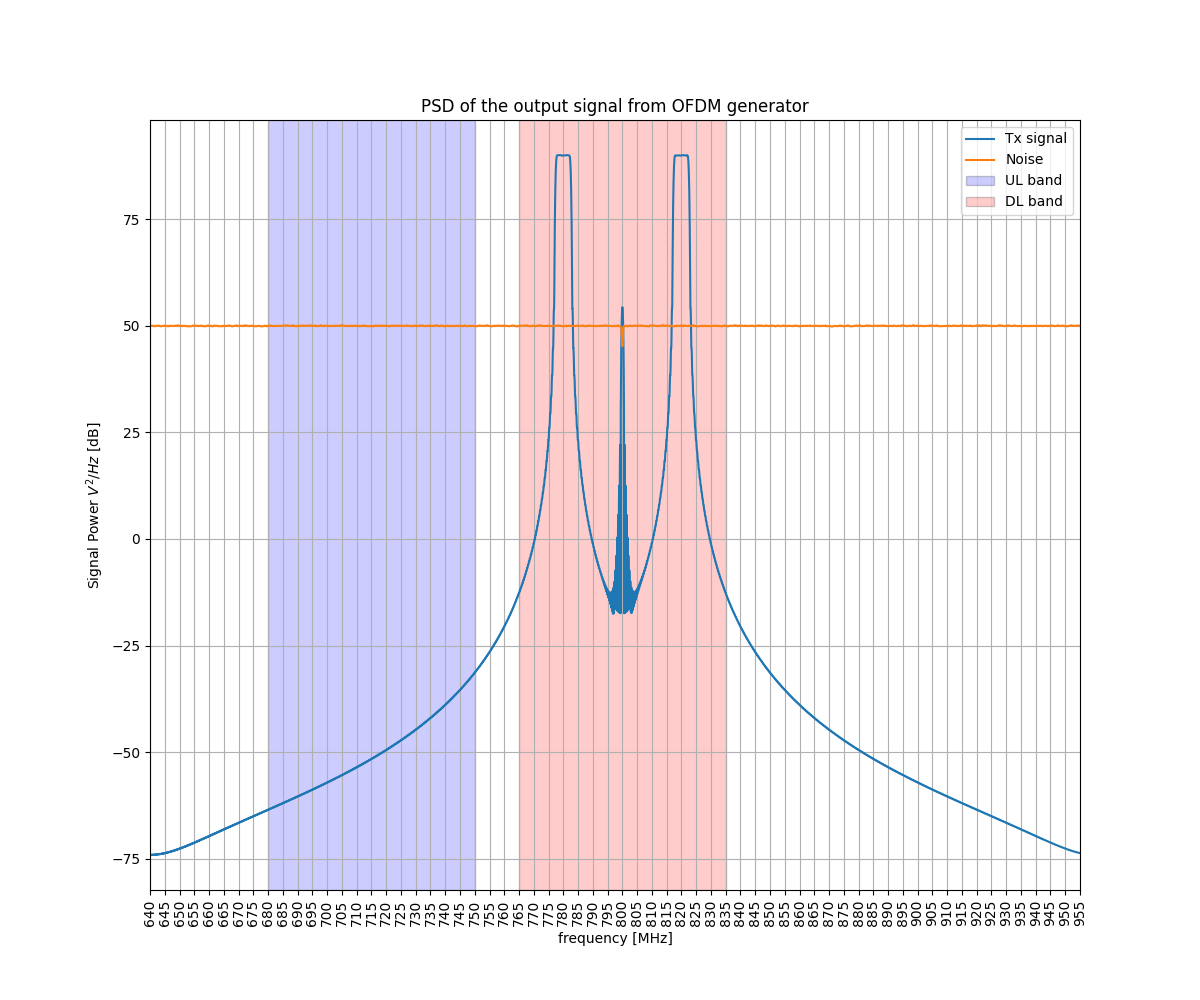

In [19]:
f, Pxx_spec = welch(np.transpose(s_amp_1+s_amp_2), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, noise_spec = welch(np.transpose(noise), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, s_rx_spec = welch(np.transpose(s_1_noised), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)

Pxx_spec = np.mean(Pxx_spec,0)
noise_spec = np.mean(noise_spec,0)
s_rx_spec = np.mean(s_rx_spec,0)

Pxx_dB=10*np.log10(np.abs(Pxx_spec)*Fs)
noise_spec_dB= 10*np.log10(np.abs(noise_spec)*Fs)
s_rx_spec_dB = 10*np.log10(np.abs(s_rx_spec)*Fs)

plt.figure(figsize=(12,10))
shift = 800e3 # in kHz
f_MHz = (f+shift) / 1e3

plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(Pxx_dB), label='Tx signal')
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(noise_spec_dB), label='Noise')
#plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(s_rx_spec_dB), label='Rx signal', alpha=0.6)
plt.xlabel('frequency [MHz]')
plt.ylabel('Signal Power $V^2/Hz$ [dB]')
# plt.ylim(bottom=0)
plt.xlim(left=(-2*Fc1+shift)/1e3, right=(2*Fc2+shift)/1e3)

# Specify the UP-link bandwidth
bandwidth_up = 70 # in MHz
Fc_up = (Fc1+shift)/1e3-1.5*bandwidth_up # in MHz
up_band = patches.Rectangle((Fc_up - bandwidth_up / 2, plt.ylim()[0]),
                          bandwidth_up, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='blue',alpha = 0.2, label='UL band')
plt.gca().add_patch(up_band)

# Specify the DL-link bandwidth
bandwidth_dl = 70 # in MHz
Fc_dl = (shift)/1e3 # in MHz
dl_band = patches.Rectangle((Fc_dl - bandwidth_dl / 2, plt.ylim()[0]),
                          bandwidth_dl, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='red',alpha = 0.2, label='DL band')
plt.gca().add_patch(dl_band)

custom_bins = np.arange(np.min(f_MHz), np.max(f_MHz), 5)
plt.xticks(custom_bins, rotation='vertical')
plt.grid()
plt.legend()
plt.title("PSD of the output signal from OFDM generator")
plt.show()

# Tx antenna array

## Functions

In [20]:
def get_raw_pattern(angle_grid,type):
    """
    Initial patterns of the antenna elements
    """
    d2r = np.pi/180
    if type == "uniform":
        F = np.ones(len(angle_grid))
    elif type == "cos1":
        F = np.cos(0.5*angle_grid*d2r)**2
    elif type == "cos2":
        F = np.cos(angle_grid*d2r)**2
    elif type == "cos3":
        F = np.abs(np.cos(angle_grid*d2r))
    elif type == "cos4":
        F = np.cos(angle_grid*d2r)**32
    else:
        None

    # pattern normalization
    # F = F / np.sqrt(np.sum(np.abs(F)**2))
    return F

In [21]:
def plot_pattern_polar_lin(phi, r, title):
    plt.title(title)
    plt.polar(phi,r)

In [22]:
def plot_pattern_polar_dB(phi, r, title):
    plt.title(title)
    plt.polar(phi,10*np.log10(r))

## Tx antenna parameters

In [23]:
angles = np.arange(0,361,1)   # array of degrees
d2r=np.pi/180

AOD_user = 22                     # angle of departure in degrees - USER location
AOD_user_rad = AOD_user * d2r

Ntx = 16                       # number of Tx antenna elements
c=3e8                         #speed of light
lambd1=c/((Fc1+shift)*1e3)
lambd2=c/((-Fc2+shift)*1e3)
d = lambd1/2                      # antenna interelement spacing

In [24]:
lambd1, lambd2, d

(0.36585365853658536, 0.38461538461538464, 0.18292682926829268)

## Tx antenna response

In [25]:
F_tx = get_raw_pattern(angles,"cos3")

def get_channel(AOD,lamb):
  m_tx = F_tx[AOD]                    # element radiation pattern
  M_tx=np.tile(m_tx,[Ntx,1])          # elements radiation pattern
  A = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(d2r*AOD)/lamb)  # basic array response
  A=A.reshape(-1,1)

  AR = A * M_tx # array response = basic array response * element radiation pattern
  return AR

In [26]:
H1 = get_channel(AOD_user,lambd1)
H2 = get_channel(AOD_user,lambd2)

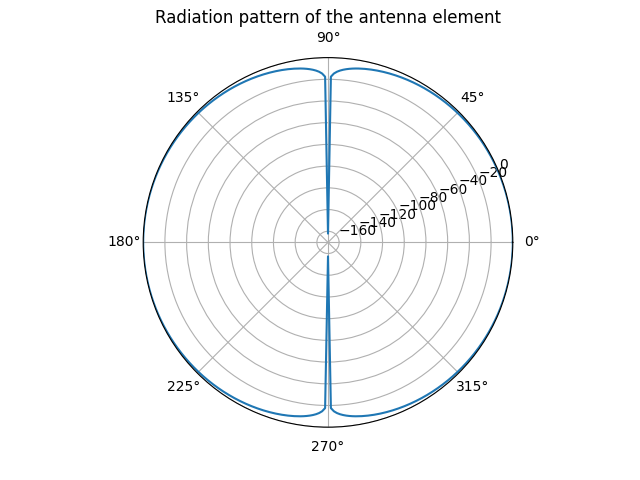

In [27]:
plt.figure()
plt.subplot(projection = 'polar')
plot_pattern_polar_dB(angles*d2r,F_tx,"Radiation pattern of the antenna element")
plt.show()

## Tx Beamforming

In [28]:
s_1_noised.shape

(4096, 1000)

In [29]:
signal_1 = s_amp_1
signal_1 = signal_1.reshape(-1,1).T

signal_2 = s_amp_2
signal_2 = signal_2.reshape(-1,1).T


# matrix multiply
tx_signal_1 = np.kron(H1,signal_1) # tx_signal now is 2D array, 1D is time and 1D is the spatial dimension
tx_signal_2 = np.kron(H2,signal_2) # tx_signal now is 2D array, 1D is time and 1D is the spatial dimension
# tx_signal_1 = np.reshape(tx_signal,(Ntx,Nfft,N))

In [30]:
signal_1.shape, tx_signal_1.shape

((1, 4096000), (16, 4096000))

### Precode our signal in case of MISO

In [31]:
w_1 = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(AOD_user_rad)/lambd1) # Conventional, aka delay-and-sum, beamformer
w_1=w_1.reshape(-1,1)/np.linalg.norm(w_1) # reshape and norm our precoder
tx_precoded_1 = w_1.conj().T @ tx_signal_1 # apply our weights. remember r is 3x10000

w_2 = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(AOD_user_rad)/lambd2) # Conventional, aka delay-and-sum, beamformer
w_2=w_2.reshape(-1,1)/np.linalg.norm(w_2) # reshape and norm our precoder
tx_precoded_2 = w_2.conj().T @ tx_signal_2 # apply our weights. remember r is 3x10000

### Plot radiation pattern of the precoded signal, spectrum of the precoded signal

In [32]:
# results = []
# for angle in angles:
#     w = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(angle*d2r)/lambd1) # Conventional, aka delay-and-sum, beamformer
#     w=w.reshape(-1,1)/np.linalg.norm(w) # reshape and norm our precoder
#     r_weighted = w.conj().T @ tx_signal_1 # apply our weights. remember r is 3x10000
#     results.append((np.mean(np.abs(r_weighted)**2))) # power in signal, in dB so its easier to see small and large lobes at the same time

In [33]:
# plt.figure()
# plt.subplot(projection = 'polar')
# plot_pattern_polar_dB(angles*d2r,np.array(results),"Radiation pattern for "+str(Ntx)
#                         +" antennas and "+str(AOD_user) + " degrees user angle")
# plt.show()

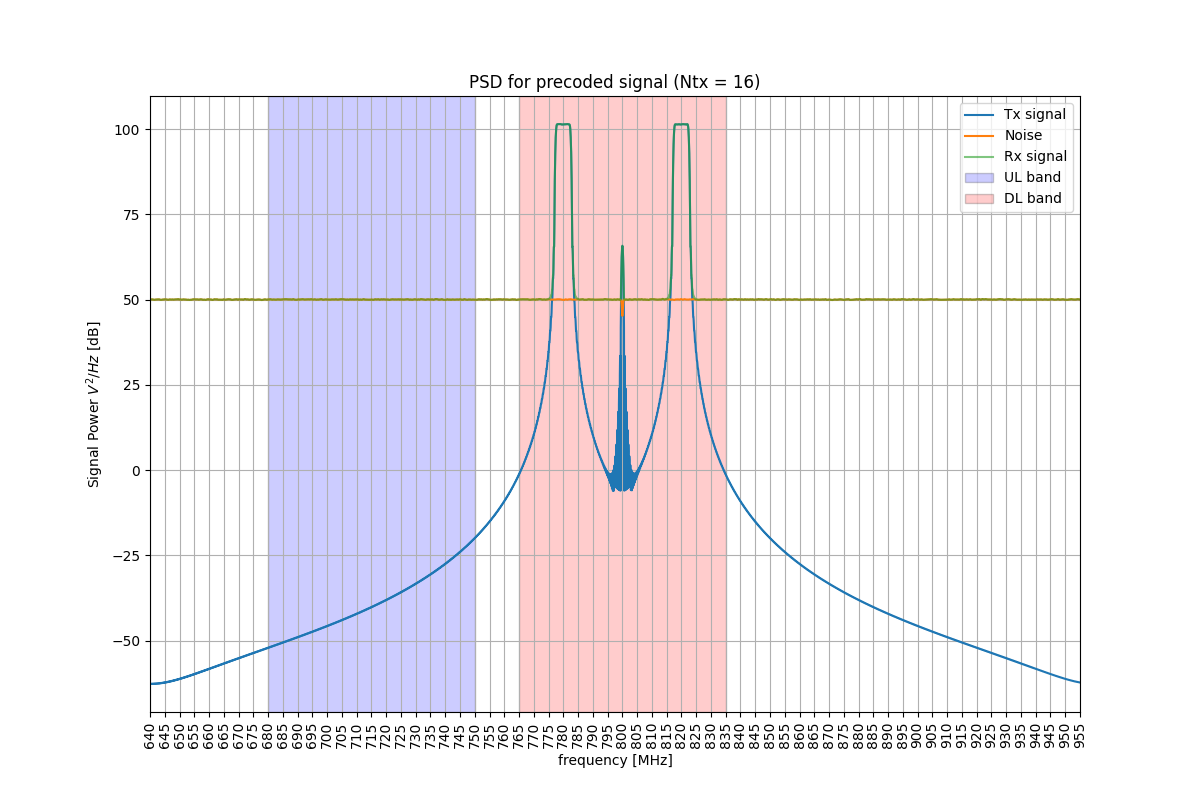

In [34]:
tx_precoded_11 = np.reshape(tx_precoded_1,(Nfft,N))
tx_precoded_22 = np.reshape(tx_precoded_2,(Nfft,N))

f, Pxx_spec = welch(np.transpose(tx_precoded_11+tx_precoded_22), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, noise_spec = welch(np.transpose(noise), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, s_rx_spec = welch(np.transpose(tx_precoded_11+tx_precoded_22+noise), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)

Pxx_spec = np.mean(Pxx_spec,0)
noise_spec = np.mean(noise_spec,0)
s_rx_spec = np.mean(s_rx_spec,0)

Pxx_dB=10*np.log10(np.abs(Pxx_spec)*Fs)
noise_spec_dB= 10*np.log10(np.abs(noise_spec)*Fs)
s_rx_spec_dB = 10*np.log10(np.abs(s_rx_spec)*Fs)

plt.figure(figsize=(12,8))
shift = 800e3 # in kHz
f_MHz = (f+shift) / 1e3

plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(Pxx_dB), label='Tx signal')
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(noise_spec_dB), label='Noise')
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(s_rx_spec_dB), label='Rx signal', alpha=0.6)
plt.xlabel('frequency [MHz]')
plt.ylabel('Signal Power $V^2/Hz$ [dB]')
# plt.ylim(bottom=0)
plt.xlim(left=(-2*Fc1+shift)/1e3, right=(2*Fc2+shift)/1e3)

# Specify the UP-link bandwidth
bandwidth_up = 70 # in MHz
Fc_up = (Fc1+shift)/1e3-1.5*bandwidth_up # in MHz
up_band = patches.Rectangle((Fc_up - bandwidth_up / 2, plt.ylim()[0]),
                          bandwidth_up, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='blue',alpha = 0.2, label='UL band')
plt.gca().add_patch(up_band)

# Specify the DL-link bandwidth
bandwidth_dl = 70 # in MHz
Fc_dl = (shift)/1e3 # in MHz
dl_band = patches.Rectangle((Fc_dl - bandwidth_dl / 2, plt.ylim()[0]),
                          bandwidth_dl, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='red',alpha = 0.2, label='DL band')
plt.gca().add_patch(dl_band)

custom_bins = np.arange(np.min(f_MHz), np.max(f_MHz), 5)
plt.xticks(custom_bins, rotation='vertical')
plt.grid()
plt.legend()
plt.title("PSD for precoded signal (Ntx = "+str(Ntx)+")")
plt.show()

# ePIM source configuration

## Input ePIM signal generation

In [35]:
F_tx = get_raw_pattern(angles,"cos3")

def get_ePIM_channel(AOD,lamb,d_PIM):
  m_tx = F_tx[AOD]                    # element radiation pattern
  M_tx=np.tile(m_tx,[Ntx,1])          # elements radiation pattern
  atten=1/np.sqrt(4*np.pi*(d_PIM-d * (np.arange(Ntx))*np.cos(d2r*(AOD+90)) + ((np.arange(Ntx))*d*np.sin(d2r*(AOD+90)))**2/(2*d_PIM))**2)
  A = atten*np.exp(-2j * np.pi/lamb * (-d * np.arange(Ntx)*np.cos(d2r*(AOD+90)) + (np.arange(Ntx)*d*np.sin(d2r*(AOD+90)))**2/(2*d_PIM)))  # basic array response
  A=A.reshape(-1,1)

  AR = A * M_tx # array response = basic array response * element radiation pattern
  return AR

In [36]:
AOD_PIM = 45                     # angle of departure in degrees - ePIM location
AOD_PIM_rad = AOD_PIM * d2r
d_PIM = 35 / 100 # distance towards ePIM

lambd3 = c/((Fc_up)*1e6)

In [37]:
H1_PIM = get_ePIM_channel(AOD_PIM,lambd1, d_PIM)
H2_PIM = get_ePIM_channel(AOD_PIM,lambd2, d_PIM)

In [38]:
H1_PIM, H2_PIM

(array([[ 0.56991754+0.j        ],
        [-0.34599083-0.19338054j],
        [ 0.2776641 +0.05580993j],
        [-0.1244508 +0.16824784j],
        [-0.15446269-0.04016687j],
        [-0.10170075-0.0728772j ],
        [-0.0989945 -0.01680549j],
        [-0.0368146 +0.07349646j],
        [ 0.06831636-0.00413083j],
        [-0.05703284-0.00947727j],
        [ 0.04492428-0.02067101j],
        [ 0.01170742+0.0411258j ],
        [-0.02188159+0.03023959j],
        [-0.02139613+0.02493557j],
        [ 0.00084674+0.02912631j],
        [ 0.02600918-0.00045406j]]),
 array([[ 0.56991754+0.j        ],
        [-0.31838388-0.23608767j],
        [ 0.24919878+0.13458109j],
        [-0.19034206+0.08697837j],
        [-0.08512263-0.13500458j],
        [ 0.01166671-0.12457133j],
        [-0.00317293-0.10036069j],
        [-0.06626175-0.04864591j],
        [-0.03384268+0.05948833j],
        [ 0.05369635-0.02143048j],
        [-0.04370642+0.02313504j],
        [ 0.0083247 -0.04194156j],
        [ 0.037147

In [39]:
signal_PIM_1 = s_amp_1
signal_PIM_1 = signal_PIM_1.reshape(-1,1).T

signal_PIM_2 = s_amp_2
signal_PIM_2 = signal_PIM_2.reshape(-1,1).T

# matrix multiply
tx_signal_PIM_1 = np.kron(H1_PIM,signal_PIM_1) # tx_signal now is 2D array, 1D is time and 1D is the spatial dimension
tx_signal_PIM_2 = np.kron(H2_PIM,signal_PIM_2) # tx_signal now is 2D array, 1D is time and 1D is the spatial dimension
# tx_signal = np.reshape(tx_signal,(Ntx,Nfft,N))

In [40]:
w = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(d2r*AOD_user)) # Apply same precoder as for USER
w=w.reshape(-1,1)/np.linalg.norm(w)
tx_precoded_PIM_1 = w.conj().T @ tx_signal_PIM_1 # apply our weights for signal towards ePIM
tx_precoded_PIM_2 = w.conj().T @ tx_signal_PIM_2 # apply our weights for signal towards ePIM

In [41]:
tx_precoded_PIM=tx_precoded_PIM_1+tx_precoded_PIM_2
tx_precoded_PIM = np.reshape(np.squeeze(tx_precoded_PIM),(Nfft,N))

## Output ePIM signal generation

In [42]:
tx_PIM_out = tx_precoded_PIM*np.abs(tx_precoded_PIM)**2
#tx_PIM_out = s_amp*np.abs(s_amp)**2

In [43]:
alpha = 0.55 # attenuation of the ePIM signal

In [44]:
Sig_pow=np.mean(np.abs(tx_precoded_PIM)**2) # current mean power of the Tx signal
power=np.mean(np.abs(tx_PIM_out)**2) # current mean power of the PIM
amp_factor = np.sqrt(Sig_pow/power)
tx_PIM_out = alpha*amp_factor*tx_PIM_out

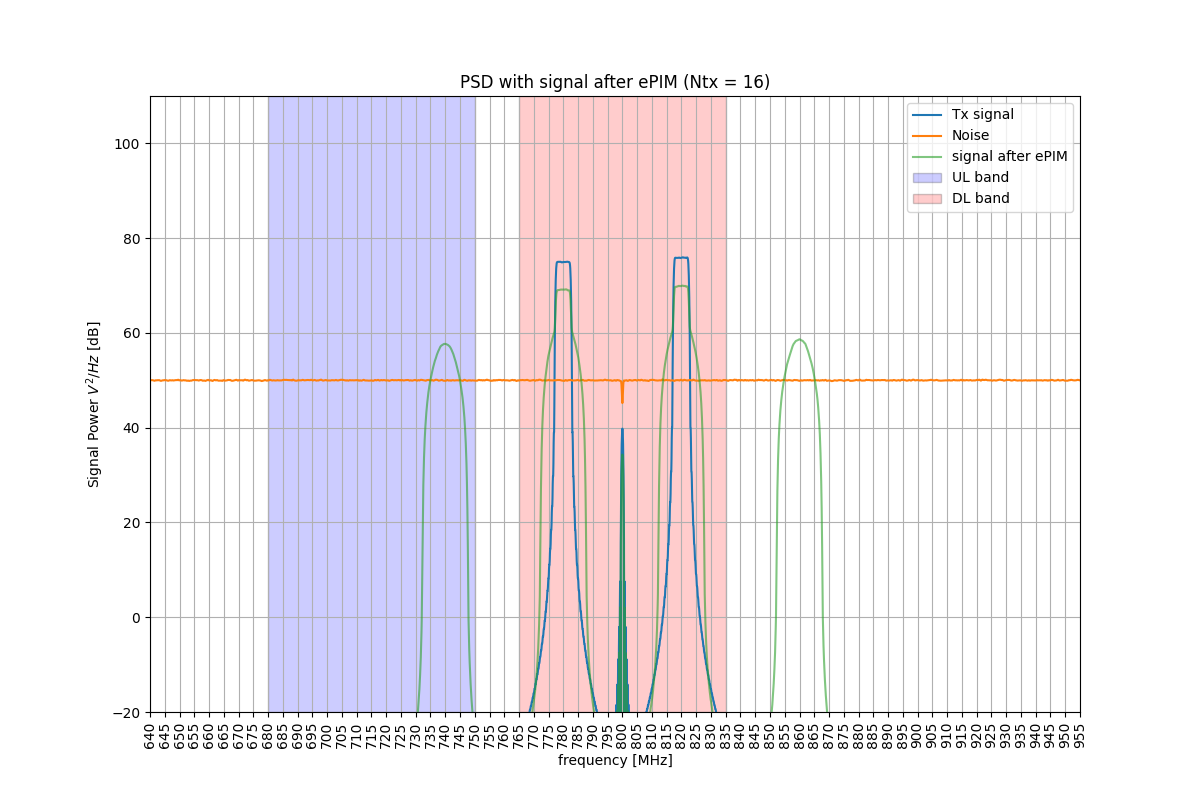

In [45]:
f, Pxx_spec = welch(np.transpose(tx_precoded_PIM), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, noise_spec = welch(np.transpose(noise), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, s_PIM = welch(np.transpose(tx_PIM_out), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)

Pxx_spec = np.mean(Pxx_spec,0)
noise_spec = np.mean(noise_spec,0)
s_PIM_spec = np.mean(s_PIM,0)

Pxx_dB=10*np.log10(np.abs(Pxx_spec)*Fs)
noise_spec_dB= 10*np.log10(np.abs(noise_spec)*Fs)
s_PIM_dB = 10*np.log10(np.abs(s_PIM_spec)*Fs)

plt.figure(figsize=(12,8))
shift = 800e3 # in kHz
f_MHz = (f+shift) / 1e3

plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(Pxx_dB), label='Tx signal')
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(noise_spec_dB), label='Noise')
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(s_PIM_dB), label='signal after ePIM', alpha=0.6)

plt.xlabel('frequency [MHz]')
plt.ylabel('Signal Power $V^2/Hz$ [dB]')
plt.ylim(bottom=-20, top=110)
plt.xlim(left=(-5*Fc1+shift)/1e3, right=(5*Fc2+shift)/1e3)

# Specify the UP-link bandwidth
bandwidth_up = 70 # in MHz
Fc_up = (Fc1+shift)/1e3-1.5*bandwidth_up # in MHz
up_band = patches.Rectangle((Fc_up - bandwidth_up / 2, plt.ylim()[0]),
                          bandwidth_up, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='blue',alpha = 0.2, label='UL band')
plt.gca().add_patch(up_band)

# Specify the DL-link bandwidth
bandwidth_dl = 70 # in MHz
Fc_dl = (shift)/1e3 # in MHz
dl_band = patches.Rectangle((Fc_dl - bandwidth_dl / 2, plt.ylim()[0]),
                          bandwidth_dl, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='red',alpha = 0.2, label='DL band')
plt.gca().add_patch(dl_band)

custom_bins = np.arange(np.min(f_MHz), np.max(f_MHz), 5)
plt.xticks(custom_bins, rotation='vertical')
plt.grid()
plt.legend()
plt.title("PSD with signal after ePIM (Ntx = "+str(Ntx)+")")
plt.show()

## ePIM signal back propagation

In [46]:
H3 = get_ePIM_channel(AOD_PIM,lambd3, d_PIM)

In [47]:
signal_PIM_bp = tx_PIM_out
signal_PIM_bp = signal_PIM_bp.reshape(-1,1).T

# matrix multiply
sig_PIM = np.kron(H3,signal_PIM_bp) # tx_signal now is 2D array, 1D is time and 1D is the spatial dimension

In [48]:
sig_PIM.shape

(16, 4096000)

In [49]:
RX_sig_PIM = np.reshape(sig_PIM,(Ntx,Nfft,N))

In [50]:
# Receiving ePIM in a certain channel:
rx_PIM=np.squeeze(RX_sig_PIM[0,:,:])+noise

In [51]:
# Filter design
lowcut = int(Fc_up - bandwidth_up / 2)
highcut = int(Fc_up + bandwidth_up / 2)

filter_f=f_MHz.copy()

for i in range(len(filter_f)):
  if (filter_f[i]<lowcut) | (filter_f[i]>highcut):
    filter_f[i]=0
  else:
    filter_f[i]=1

## Plot received ePIM signal

### Plot power by channel

In [52]:
RX_sig_PIM_mean = np.squeeze(np.mean(RX_sig_PIM,2))
# RX_sig_PIM_mean = np.squeeze(np.squeeze(RX_sig_PIM[:,:,5]))
print(RX_sig_PIM_mean.shape)

print(int(np.mean(np.abs(RX_sig_PIM_mean)**2))/Ntx)

(16, 4096)
0.8125


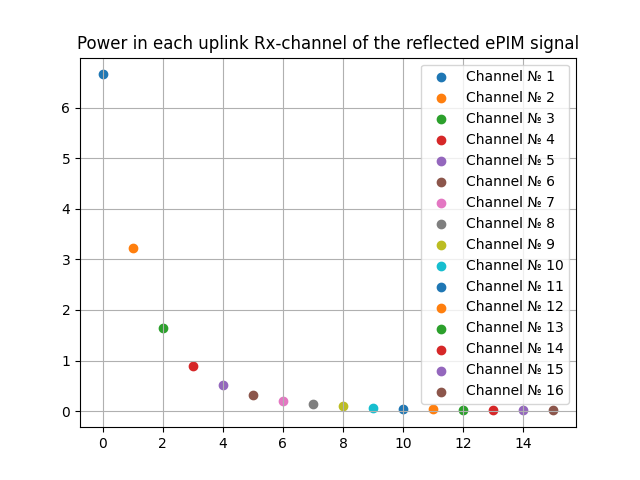

In [53]:
plt.figure()
for i in range(Ntx):
  namelabel = "Channel № " + str(i+1)
  plt.scatter(i,(np.mean(np.abs(RX_sig_PIM_mean[i,:])**2)/Ntx), label=namelabel)
plt.legend()
plt.grid()
plt.title("Power in each uplink Rx-channel of the reflected ePIM signal")
plt.show()

### Plot PSD with received PIM signal

In [54]:
# FFT=np.fft.fftn(s_amp,axes=(0,))
# FFT=np.mean(FFT,1)

# plt.figure()
# plt.plot(np.fft.fftshift(f_MHz),10 * np.log10(np.fft.fftshift(np.abs(FFT))**2))
# plt.show()
# #plt.close('all')

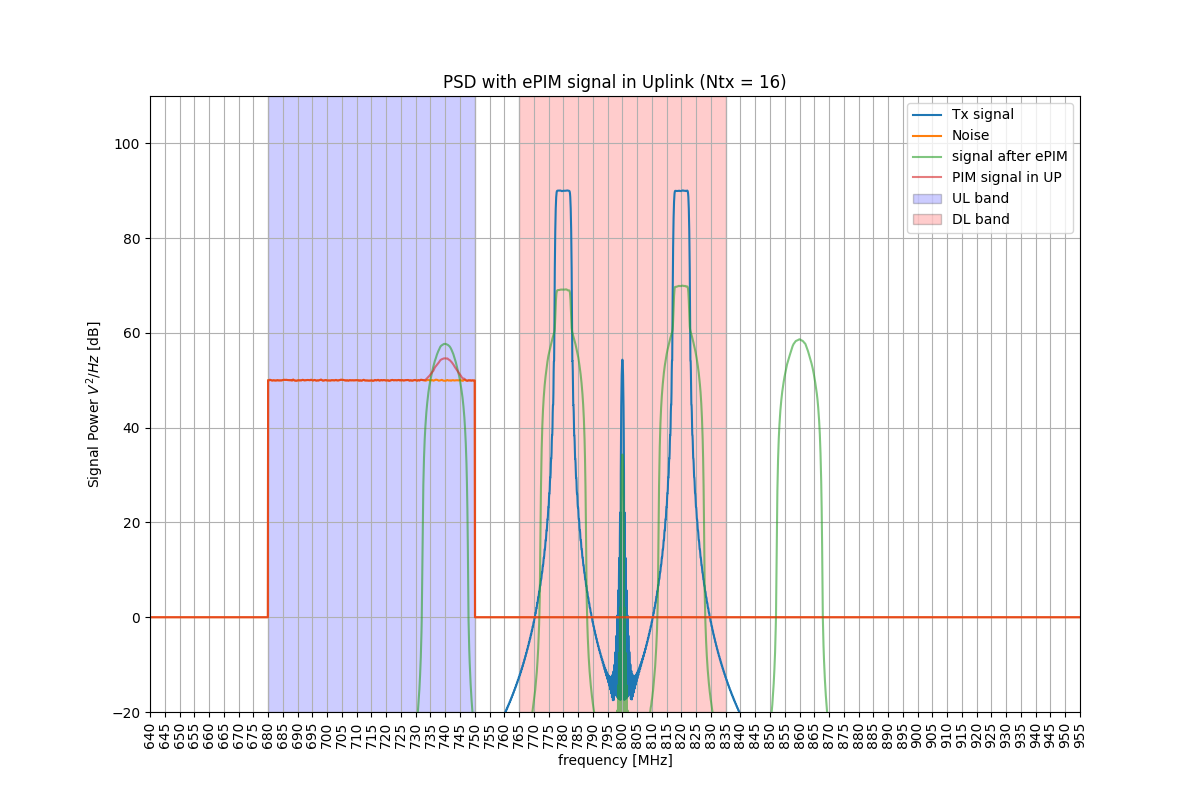

In [55]:
f, Pxx_spec = welch(np.transpose(s_amp_1+s_amp_2), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, noise_spec = welch(np.transpose(noise), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, s_PIM = welch(np.transpose(tx_PIM_out), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)
_, s_rx_PIM = welch(np.transpose(rx_PIM), Fs, nperseg=nperseg, nfft=Nfft, return_onesided=False)


Pxx_spec = np.mean(Pxx_spec,0)
noise_spec = np.mean(noise_spec,0)
s_PIM_spec = np.mean(s_PIM,0)
s_rx_PIM_spec = np.mean(s_rx_PIM,0)


Pxx_dB=10*np.log10(np.abs(Pxx_spec)*Fs)
noise_spec_dB= 10*np.log10(np.abs(noise_spec)*Fs)
s_PIM_dB = 10*np.log10(np.abs(s_PIM_spec)*Fs)
s_rx_PIM_dB = 10*np.log10(np.abs(s_rx_PIM_spec)*Fs)

## Applying filter in UP-link
s_rx_PIM_dB=s_rx_PIM_dB*filter_f
noise_spec_dB = noise_spec_dB*filter_f

plt.figure(figsize=(12,8))
shift = 800e3 # in kHz
f_MHz = (f+shift) / 1e3

plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(Pxx_dB), label='Tx signal')
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(noise_spec_dB), label='Noise')
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(s_PIM_dB), label='signal after ePIM', alpha=0.6)
plt.plot(np.fft.fftshift(f_MHz), np.fft.fftshift(s_rx_PIM_dB), label='PIM signal in UP', alpha=0.6)
plt.xlabel('frequency [MHz]')
plt.ylabel('Signal Power $V^2/Hz$ [dB]')
plt.ylim(bottom=-20, top=110)
plt.xlim(left=(-5*Fc1+shift)/1e3, right=(5*Fc2+shift)/1e3)

# Specify the UP-link bandwidth
bandwidth_up = 70 # in MHz
Fc_up = (Fc1+shift)/1e3-1.5*bandwidth_up # in MHz
up_band = patches.Rectangle((Fc_up - bandwidth_up / 2, plt.ylim()[0]),
                          bandwidth_up, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='blue',alpha = 0.2, label='UL band')
plt.gca().add_patch(up_band)

# Specify the DL-link bandwidth
bandwidth_dl = 70 # in MHz
Fc_dl = (shift)/1e3 # in MHz
dl_band = patches.Rectangle((Fc_dl - bandwidth_dl / 2, plt.ylim()[0]),
                          bandwidth_dl, plt.ylim()[1] - plt.ylim()[0],
                          linewidth=1, edgecolor='black', facecolor='red',alpha = 0.2, label='DL band')
plt.gca().add_patch(dl_band)

custom_bins = np.arange(np.min(f_MHz), np.max(f_MHz), 5)
plt.xticks(custom_bins, rotation='vertical')
plt.grid()
plt.legend()
plt.title("PSD with ePIM signal in Uplink (Ntx = "+str(Ntx)+")")
plt.show()

# Original vs optimized beamforming

## Optimized beamforming realization

In [315]:
F_tx = get_raw_pattern(angles,"cos3")

def get_ePIM_channel2(AOD,lamb,d_PIM):
  m_tx = F_tx[AOD]                    # element radiation pattern
  M_tx=np.tile(m_tx,[Ntx,1])          # elements radiation pattern
  # atten=1/np.sqrt(4*np.pi*(d_PIM-d * (np.arange(Ntx))*np.cos(d2r*(AOD+90)) + ((np.arange(Ntx))*d*np.sin(d2r*(AOD+90)))**2/(2*d_PIM))**2)
  A = np.exp(-2j * np.pi/lamb * (-d * np.arange(Ntx)*np.cos(d2r*(AOD+90)) + (np.arange(Ntx)*d*np.sin(d2r*(AOD+90)))**2/(2*d_PIM)))  # basic array response
  A=A.reshape(-1,1)

  AR = A * M_tx # array response = basic array response * element radiation pattern
  return AR

In [316]:
w_1 = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(AOD_user*d2r)/lambd1) # Conventional, aka delay-and-sum, beamformer
w_1=w_1.reshape(-1,1)/np.linalg.norm(w_1) # reshape and norm our precoder
w_1=np.conj(w_1)
#w_1-H1.conj()/np.linalg.norm(H1)

In [317]:
H1_PIM = get_channel(AOD_PIM,lambd1)
H1 = get_channel(AOD_user,lambd1)

In [ ]:
H1_PIM = get_ePIM_channel2(AOD_PIM,lambd1,d_PIM)
H1 = get_ePIM_channel2(AOD_user,lambd1,5000)

In [318]:
get_channel(AOD_user,lambd1), get_ePIM_channel2(AOD_user,lambd1,5000)

(array([[ 0.39073113+0.j        ],
        [ 0.14997237-0.36080341j],
        [-0.27560484-0.27697073j],
        [-0.36154042+0.14818684j],
        [-0.00193165+0.39072635j],
        [ 0.36005759+0.15175423j],
        [ 0.27832984-0.27423222j],
        [-0.14639769-0.36226859j],
        [-0.39071203-0.00386325j],
        [-0.15353238+0.35930297j],
        [ 0.2728529 +0.27968216j],
        [ 0.3629879 -0.14460497j],
        [ 0.00579475-0.39068816j],
        [-0.35853956-0.15530678j],
        [-0.28102764+0.27146691j],
        [ 0.14280871+0.36369835j]]),
 array([[ 0.39073113+0.j        ],
        [ 0.14995454-0.36081082j],
        [-0.27565957-0.27691626j],
        [-0.36147449+0.14834758j],
        [-0.00162279+0.39072776j],
        [ 0.36024475+0.15130941j],
        [ 0.27784167-0.27472681j],
        [-0.14727424-0.36191313j],
        [-0.39072229-0.00262786j],
        [-0.15209334+0.35991448j],
        [ 0.2742313 +0.27833076j],
        [ 0.362117  -0.14677226j],
        [ 0.003015

In [319]:
np.linalg.norm(get_channel(AOD_user,lambd1)-get_ePIM_channel2(AOD_user,lambd1,5000))

0.008151281547484082

In [320]:
np.abs(w_1.T@H1)

array([[1.56292451]])

In [321]:
np.abs(H1.T@w_1_optimized)

array([[1.51047199]])

In [446]:
plt.close('all')

In [323]:
print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']


In [339]:
import cvxpy as cp
import numpy as np

x = cp.Variable((len(H1),1), complex = True)
# print(x.shape)

objective = cp.Maximize(cp.real(w_1.conj().T@x))+cp.Maximize(cp.imag(w_1.conj().T@x))
k=50
u = 10**((10*np.log10(np.abs(H1_PIM.T@w_1))-k)/10)
constraints = [cp.abs((H1_PIM.T@x)) <= u]
# constraints += [
#     cp.abs(x) <= 1
# ]
constraints += [
    cp.norm(x) <= 1
]
# Create and solve our convex linear optimization problem.
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.CVXOPT,verbose=True, max_iters=500,abstol=1e-10)

# See what our solution is:
print(problem.value)
print(x.value)

w_1_optimized = (x.value)

                                     CVXPY                                     
                                     v1.3.3                                    
(CVXPY) Mar 18 03:01:49 PM: Your problem has 16 variables, 2 constraints, and 0 parameters.
(CVXPY) Mar 18 03:01:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 18 03:01:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 18 03:01:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 18 03:01:49 PM: Compiling problem (target solver=CVXOPT).
(CVXPY) Mar 18 03:01:49 PM: Reduction chain: Complex2Real -> FlipObjective -> Dcp2Cone -> CvxA

In [340]:
u[0,0]

3.1589664376759686e-06

In [341]:
np.abs((H1_PIM.T@w_1))

array([[0.31589664]])

In [342]:
np.abs(H1_PIM.T@w_1_optimized)

array([[7.6215537e-07]])

In [343]:
10*np.log10(np.abs(H1_PIM.T@w_1_optimized))

array([[-61.17956486]])

In [344]:
10*np.log10(np.abs(H1_PIM.T@w_1)**2)

array([[-10.00909976]])

In [345]:
np.log10(np.abs(H1_PIM.T@w_1_optimized))-np.log10(np.abs(w_1.T@H1_PIM))

array([[-5.6175015]])

In [346]:
w_1_optimized, w_1

(array([[ 0.15794467+0.19698966j],
        [-0.09913943+0.20506364j],
        [-0.22777357+0.01471424j],
        [-0.12270956-0.22165304j],
        [ 0.18423002-0.20537127j],
        [ 0.24976732+0.11672829j],
        [-0.02574897+0.25160795j],
        [-0.21488658+0.07622855j],
        [-0.17215878-0.14949377j],
        [ 0.06799291-0.24361144j],
        [ 0.27515028-0.01736473j],
        [ 0.09642269+0.25849704j],
        [-0.19523207+0.16146871j],
        [-0.20663711-0.09694542j],
        [-0.01733154-0.22711086j],
        [ 0.2190152 -0.12563355j]]),
 array([[ 0.25      -0.j        ],
        [ 0.09595625+0.23085146j],
        [-0.17633919+0.17721312j],
        [-0.23132302-0.09481382j],
        [-0.00123592-0.24999694j],
        [ 0.23037427-0.09709633j],
        [ 0.17808272+0.17546095j],
        [-0.09366908+0.23178892j],
        [-0.24998778+0.00247181j],
        [-0.09823404-0.22989144j],
        [ 0.17457843-0.17894796j],
        [ 0.23224916+0.09252204j],
        [ 0.003707

In [347]:
angles = np.linspace(-89,89,179)
results = np.zeros(np.size(angles))
results_opt= np.zeros(np.size(angles))

for i,angle in enumerate(angles):
    H_1_i = get_channel(int(angle),lambd1)
    r_weighted = H_1_i.T @ w_1 # original beamform
    r_weighted_opt = H_1_i.T @ w_1_optimized # optimized beamform

    results[i]=np.abs(r_weighted[0,0])
    results_opt[i]=np.abs(r_weighted_opt[0,0])

    if angle == AOD_user:
      print("ORIGINAL precoded channel gain towards USER ",results[i])
      print("OPT precoded channel gain towards USER ", results_opt[i])
    if angle == AOD_PIM:
      print("ORIGINAL precoded channel gain towards ePIM ",results[i])
      print("OPT precoded channel gain towards ePIM ", results_opt[i])

ORIGINAL precoded channel gain towards USER  1.5629245139570949
OPT precoded channel gain towards USER  1.553476975822456
ORIGINAL precoded channel gain towards ePIM  0.3158966437675967
OPT precoded channel gain towards ePIM  7.621553697887176e-07


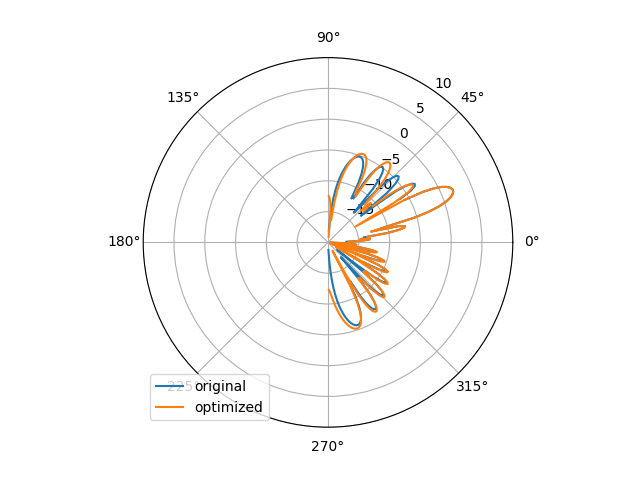

In [348]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angles*d2r, 10*np.log10(np.array(results)),label='original') # MAKE SURE TO USE RADIAN FOR POLAR
ax.plot(angles*d2r, 10*np.log10(np.array((results_opt))),label='optimized') # MAKE SURE TO USE RADIAN FOR POLAR
ax.set_rlabel_position(55)  # Move grid labels away from other labels
ax.set_rlim(bottom=-20,top=10)
plt.legend(loc='lower left')
plt.show()

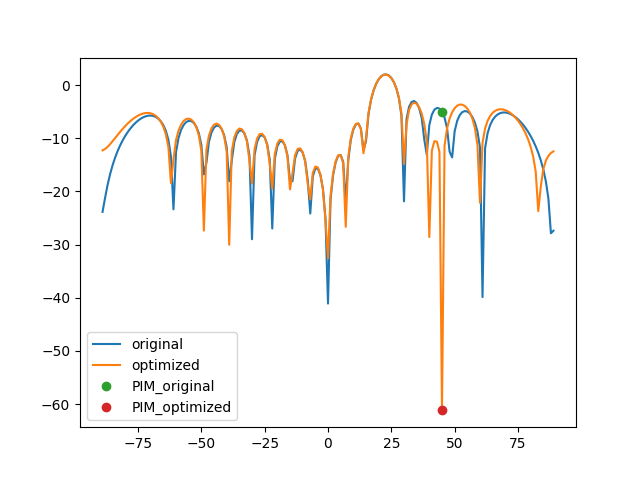

In [349]:
plt.figure()
plt.plot(angles, 10*np.log10(np.array(results)),label='original') # MAKE SURE TO USE RADIAN FOR POLAR
plt.plot(angles, 10*np.log10(np.array((results_opt))),label='optimized') # MAKE SURE TO USE RADIAN FOR POLAR
plt.plot(angles[134], 10*np.log10(np.array(results[134])),'o',label='PIM_original') # MAKE SURE TO USE RADIAN FOR POLAR
plt.plot(angles[134], 10*np.log10(np.array((results_opt[134]))),'o',label='PIM_optimized')
plt.legend(loc='lower left')
plt.show()

## Gradient descent method

In [457]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm

# Define the cost function
def custom_cost(w_opt, w, P, c, u):
    return -tf.abs((tf.linalg.adjoint(w_opt) @ w))**2 + c * tf.maximum(0, (tf.abs(tf.transpose(P) @ w_opt) - tf.abs(u)))**2

# Create needed objects
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
w_opt = tf.Variable(np.random.normal(size=(len(w_1), 1))+1j*np.random.normal(size=(len(w_1), 1)), dtype=tf.complex128)  # Variable vector [N, 1]
# Normalize w_opt
w_opt.assign(w_opt / tf.norm(w_opt))

w = w_1  # Vector w [N, 1]
P = H1_PIM  # Vector P [N, 1]
k = 50
c = 20  # Define your c
u = 10**((10*np.log10(np.abs(H1_PIM.T@w_1)**2)-k)/10)

# Perform optimization
for _ in tqdm(range(1000)):
    with tf.GradientTape() as tape:
        cost = custom_cost(w_opt, w, P, c, u)
    gradients = tape.gradient(cost, [w_opt])
    sgd.apply_gradients(zip(gradients, [w_opt]))

    # Normalize w_opt
    w_opt.assign(w_opt / tf.norm(w_opt))
# Extract results
print("Optimized variable w_opt:")
print(w_opt.numpy())
print("Final cost:")
print(custom_cost(w_opt, w, P, c, u).numpy())


100%|██████████| 1000/1000 [00:14<00:00, 68.64it/s]

Optimized variable w_opt:
[[-0.1454747 +0.20635417j]
 [-0.22463462-0.03848563j]
 [-0.07709946-0.21497416j]
 [ 0.17916633-0.17910343j]
 [ 0.248153  +0.12023813j]
 [-0.04299068+0.27217778j]
 [-0.24886929+0.04500935j]
 [-0.13284549-0.18547409j]
 [ 0.09618158-0.20687596j]
 [ 0.25289965-0.00187942j]
 [ 0.09267435+0.25950029j]
 [-0.22157938+0.16413317j]
 [-0.2092479 -0.14280733j]
 [ 0.03593507-0.22553688j]
 [ 0.21361497-0.07943871j]
 [ 0.18118849+0.17582849j]]
Final cost:
[[-0.98801838]]


In [458]:
angles = np.linspace(-89,89,179)
results = np.zeros(np.size(angles))
results_opt= np.zeros(np.size(angles))

for i,angle in enumerate(angles):
    H_1_i = get_channel(int(angle),lambd1)
    r_weighted = H_1_i.T @ w # original beamform
    r_weighted_opt = H_1_i.T @ w_opt.numpy() # optimized beamform

    results[i]=np.abs(r_weighted[0,0])
    results_opt[i]=np.abs(r_weighted_opt[0,0])

    if angle == AOD_user:
      print("ORIGINAL precoded channel gain towards USER ",results[i])
      print("OPT precoded channel gain towards USER ", results_opt[i])
    if angle == AOD_PIM:
      print("ORIGINAL precoded channel gain towards ePIM ",results[i])
      print("OPT precoded channel gain towards ePIM ", results_opt[i])

ORIGINAL precoded channel gain towards USER  1.5629245139570949
OPT precoded channel gain towards USER  1.5535889925305422
ORIGINAL precoded channel gain towards ePIM  0.3158966437675967
OPT precoded channel gain towards ePIM  0.0018861219935256961


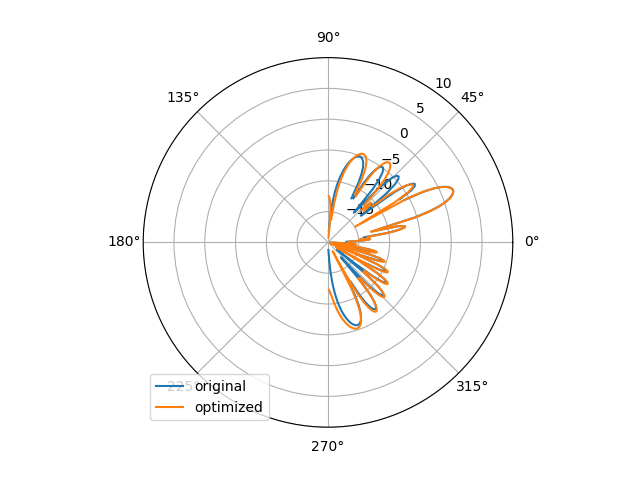

In [459]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angles*d2r, 10*np.log10(np.array(results)),label='original') # MAKE SURE TO USE RADIAN FOR POLAR
ax.plot(angles*d2r, 10*np.log10(np.array((results_opt))),label='optimized') # MAKE SURE TO USE RADIAN FOR POLAR
ax.set_rlabel_position(55)  # Move grid labels away from other labels
ax.set_rlim(bottom=-20,top=10)
plt.legend(loc='lower left')
plt.show()

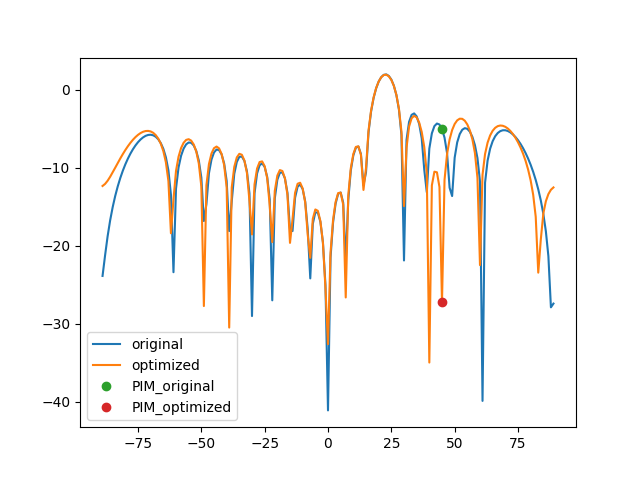

In [460]:
plt.figure()
plt.plot(angles, 10*np.log10(np.array(results)),label='original') # MAKE SURE TO USE RADIAN FOR POLAR
plt.plot(angles, 10*np.log10(np.array((results_opt))),label='optimized') # MAKE SURE TO USE RADIAN FOR POLAR
plt.plot(angles[134], 10*np.log10(np.array(results[134])),'o',label='PIM_original') # MAKE SURE TO USE RADIAN FOR POLAR
plt.plot(angles[134], 10*np.log10(np.array((results_opt[134]))),'o',label='PIM_optimized')
plt.legend(loc='lower left')
plt.show()

## Some mess-code


In [241]:
import cvxpy as cp
import numpy as np

# How much it costs to go around the edges of our network
  # (the weight of each edge)

# Instead of initializing x1, x2, ..., x9, we can instead initialize
  # x to be a vector with 9 entries.
x = cp.Variable((len(H1),len(H1)), complex = True)
# print(x.shape)

# Similiar to NumPy, represent matrix multiplication in CVXPY with @
objective = cp.Maximize(cp.real(cp.trace(x@H1@cp.conj(H1.T))))+cp.Maximize(cp.imag(cp.trace(x@H1@cp.conj(H1.T))))


# Remember: Constraints must be in list form!
  # Additionally, since we said in the creation of the x-variable that
    # it must be non-negative, the only constraint we need to include is that
    # each value of x cannot be greater than 6.
u = 10**(10*np.log10(np.abs(H1_PIM.T@H1)**2)-15)
constraints = [cp.abs(cp.trace(x@H1_PIM@cp.conj(H1_PIM.T))) <= u]
constraints += [
    cp.norm(x) <= 1
]
constraints +=  [x>>0]

# Create and solve our convex linear optimization problem.
problem = cp.Problem(objective, constraints)
problem.solve(problem.value)

# See what our solution is:
print(problem.value)
print(x.value)

19.257560488055717
[[ 3.31316283e-02+3.76326101e-02j -1.53583991e-02+3.88700442e-02j
  -4.66816318e-02+7.76379739e-03j -1.86056371e-02-4.22310750e-02j
   3.00104352e-02-3.77477168e-02j  4.37489997e-02+1.23419710e-02j
   4.27062677e-03+4.48969628e-02j -4.00383393e-02+2.13506024e-02j
  -3.60198528e-02-2.88526565e-02j  1.38696788e-02-4.51628263e-02j
   4.57986131e-02-3.80980360e-03j  2.22398404e-02+4.13746851e-02j
  -2.90743002e-02+3.56678972e-02j -4.40205430e-02-1.37265078e-02j
  -4.16711445e-03-4.61030349e-02j  4.08336841e-02-2.16034395e-02j]
 [ 6.27463250e-02+3.88835153e-03j  2.62211779e-02+4.13843973e-02j
  -2.96587864e-02+5.78499967e-02j -5.53051344e-02-1.57545302e-02j
  -1.45632431e-02-6.30538136e-02j  4.69735019e-02-3.64957172e-02j
   4.94510619e-02+3.01128888e-02j -9.03947100e-03+5.77657347e-02j
  -5.85810788e-02+1.46668851e-02j -3.49938966e-02-5.10578482e-02j
   3.22479945e-02-4.93320194e-02j  6.05652908e-02+1.06344114e-02j
   1.37178466e-02+5.80340567e-02j -4.87836502e-02+3.3836

/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [242]:
eigenvalues, eigenvectors = np.linalg.eig(x.value)
np.abs(eigenvalues), eigenvectors

(array([9.89969546e-01, 1.06564018e-02, 4.96341439e-05, 4.72616325e-05,
        4.75962591e-05, 4.76999679e-05, 4.77339484e-05, 4.77332748e-05,
        4.77425379e-05, 4.77651867e-05, 4.77487163e-05, 4.77607597e-05,
        4.77564933e-05, 4.77583940e-05, 4.77555377e-05, 4.77542448e-05]),
 array([[-1.26053422e-01+1.36316337e-01j,  6.69944390e-01+0.00000000e+00j,
          5.30284507e-01+0.00000000e+00j,  3.97637001e-02-4.09312890e-01j,
          1.07239186e-01+5.20427427e-02j,  1.37432451e-02+1.40715638e-02j,
         -1.88009586e-02-1.49479708e-02j, -4.89429646e-04-1.39689721e-02j,
          7.25929754e-03-1.43575968e-03j,  1.70055664e-03+2.27609677e-03j,
         -5.67808820e-03+1.15840654e-03j,  4.94308093e-03-5.95889370e-04j,
         -6.04011267e-03+1.01137157e-03j, -1.90972544e-03-8.12190341e-05j,
          1.25876726e-03-5.02085934e-04j,  2.31701596e-04+1.14511396e-03j],
        [ 3.91976698e-02+2.36694984e-01j, -4.27155494e-01-2.05373823e-01j,
          4.45723582e-01-1.4248658

In [243]:
max_value=np.argmax(np.abs(eigenvalues))
eigenvalues[max_value], np.abs(eigenvectors[max_value])

((0.6926683789498095+0.7072836904395848j),
 array([0.18566531, 0.66994439, 0.53028451, 0.41123982, 0.11920021,
        0.01966941, 0.02401911, 0.01397754, 0.00739992, 0.00284122,
        0.00579505, 0.00497887, 0.0061242 , 0.00191145, 0.00135521,
        0.00116832]))

In [246]:
w_1_optimized=np.sqrt(eigenvalues[max_value])*eigenvectors[max_value]
w_1_optimized=w_1_optimized.reshape(len(H1),1)
w_1_optimized

array([[-1.68177615e-01+7.64338468e-02j],
       [ 6.14496047e-01+2.58298607e-01j],
       [ 4.86395197e-01+2.04452416e-01j],
       [ 1.94284164e-01-3.60104880e-01j],
       [ 7.82982722e-02+8.90817104e-02j],
       [ 7.18045339e-03+1.82056624e-02j],
       [-1.14816615e-02-2.09595462e-02j],
       [ 4.93684773e-03-1.30015226e-02j],
       [ 7.21203795e-03+1.48191075e-03j],
       [ 6.82254698e-04+2.74336782e-03j],
       [-5.65476420e-03-1.12666969e-03j],
       [ 4.76371044e-03+1.35924603e-03j],
       [-5.93013582e-03-1.40111459e-03j],
       [-1.72035170e-03-8.10795947e-04j],
       [ 1.34816503e-03+2.47901275e-05j],
       [-2.28976655e-04+1.13967101e-03j]])

In [277]:
w_1.shape, H1.shape

((16, 1), (16, 1))

In [314]:
tx_opt_prc_1 = w_1_optimized @ signal_1 # apply our weights. remember r is 3x10000

In [292]:
w_1 = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(AOD_user*d2r)/lambd1) # Conventional, aka delay-and-sum, beamformer
w_1=w_1.reshape(-1,1)/np.linalg.norm(w_1) # reshape and norm our precoder
tx_precoded_1 = np.conj(w_1) @ signal_1 # apply our weights. remember r is 3x10000
# tx_precoded_1 = np.kron(H1,signal_1) # apply our weights. remember r is 3x10000

In [315]:
w_1, w_1_optimized

(array([[ 0.25      +0.j        ],
        [ 0.09595625-0.23085146j],
        [-0.17633919-0.17721312j],
        [-0.23132302+0.09481382j],
        [-0.00123592+0.24999694j],
        [ 0.23037427+0.09709633j],
        [ 0.17808272-0.17546095j],
        [-0.09366908-0.23178892j],
        [-0.24998778-0.00247181j],
        [-0.09823404+0.22989144j],
        [ 0.17457843+0.17894796j],
        [ 0.23224916-0.09252204j],
        [ 0.00370763-0.24997251j],
        [-0.22940299-0.09936934j],
        [-0.17980883+0.17369163j],
        [ 0.09137275+0.23270372j]]),
 array([[ 0.0820466 +0.20117381j],
        [-0.04538896+0.18704653j],
        [-0.29747487+0.02106776j],
        [-0.0697904 -0.20943917j],
        [ 0.20233508-0.19243254j],
        [ 0.24833845+0.07885676j],
        [ 0.01798475+0.24585009j],
        [-0.2234004 +0.10968855j],
        [-0.19213002-0.17485385j],
        [ 0.10336297-0.2383166j ],
        [ 0.2441707 -0.00484785j],
        [ 0.09948164+0.23949011j],
        [-0.171057

In [316]:
np.linalg.norm(w_1), np.linalg.norm(w_1_optimized)

(1.0, 1.0000000027549842)

In [ ]:
# # results -= np.max(results)
# plt.figure()
# plt.subplot(projection = 'polar')
# plot_pattern_polar_dB(angles*d2r,np.array(results),"Radiation pattern for "+str(Ntx)
#                         +" antennas and "+str(AOD_user) + " degrees user angle")
# plt.show()

# Calibration: locating ePIM

In [ ]:
# Pilot signal generation
# Ntx = 16
sample_rate = 1e6
N_samples = 10000 # number of samples to simulate

# Create a tone to act as the pilot signal
t = np.arange(N_samples)/sample_rate # time vector
f_tone = 820e6
lambd0=f_tone/c
tx_pilot = np.exp(2j * np.pi* f_tone * t)
tx_pilot=tx_pilot.reshape(1,-1)

In [ ]:
def Precode(signal,AOD_c,lamb):
  w = np.exp(-2j * np.pi * d * np.arange(Ntx) * np.sin(d2r*AOD_c)/lamb) # Conventional, aka delay-and-sum, beamformer
  w=w.reshape(-1,1)/np.linalg.norm(w) # reshape and norm our precoder
  signal_precoded = w.conj().T @ signal # apply our weights. remember r is 3x10000
  return signal_precoded

## ePIM source configuration

In [ ]:
AOD_PIM_c = 52                     # angle of departure in degrees - ePIM location
AOD_PIM_rad_c = AOD_PIM * d2r

H_PIM = get_channel(AOD_PIM_c,lambd0)       # channel towards ePIM source

## Main loop

In [ ]:
angles_calib=np.array(np.linspace(-90, 90, num=35))
power_pilot = np.zeros(angles_calib.shape)
k=0
for AOD_angle in angles_calib:
  tx_pilot_ANT = np.kron(H_PIM,tx_pilot)           # signal in channel towards ePIM
  pilot_precoded = Precode(tx_pilot_ANT,AOD_angle,lambd0) # precoded TX signal towards AOD_angle out

  pilot_PIM_out = pilot_precoded*np.abs(pilot_precoded)**2 # ePIM out

  pilot_PIM_out = pilot_PIM_out.reshape(1,-1)
  rx_pilot_PIM = np.kron(H_PIM,pilot_PIM_out)     # rx ePIM on BS

  power_pilot[k]=(np.mean(np.abs(rx_pilot_PIM)**2))/Ntx**2
  k=k+1

xnew = np.linspace(-90, 90, num=181)
spl = CubicSpline(angles_calib, power_pilot)
ynew=spl(xnew)

print("ePIM located at ", xnew[np.argmax(ynew)])

In [ ]:
#ynew = np.interp(xnew, angles_calib, power_pilot) # linear interp
plt.figure()
plt.plot(xnew, ynew, '-', label='cubic spline interp')
plt.plot(angles_calib, power_pilot, 'o', label='data')
plt.legend(loc='best')
plt.title("ePIM location interpolation")
plt.show()

## Estimating error of founded angle

In [ ]:
all_angles = np.array(np.linspace(-85, 85, num=171),dtype=int)
all_errors = np.zeros(all_angles.shape)
all_errors_lin = np.zeros(all_angles.shape)

In [ ]:
p=0
amount = 25  # number of calibration rays
angles_calib=np.array(np.linspace(-90, 90, num=amount))
power_pilot = np.zeros(angles_calib.shape)

for angle in tqdm(all_angles):
  AOD_PIM_c = angle                 # angle of departure in degrees - ePIM location
  AOD_PIM_rad_c = AOD_PIM * d2r

  H_PIM = get_channel(AOD_PIM_c,lambd0)   # channel towards ePIM source
  k=0
  for AOD_angle in angles_calib:
    tx_pilot_ANT = np.kron(H_PIM,tx_pilot)           # signal in channel towards ePIM
    pilot_precoded = Precode(tx_pilot_ANT,AOD_angle,lambd0) # precoded TX signal towards AOD_angle out

    pilot_PIM_out = pilot_precoded*np.abs(pilot_precoded)**2 # ePIM out

    pilot_PIM_out = pilot_PIM_out.reshape(1,-1)
    rx_pilot_PIM = np.kron(H_PIM,pilot_PIM_out)     # rx ePIM on BS

    power_pilot[k]=(np.mean(np.abs(rx_pilot_PIM)**2))/Ntx**2
    k=k+1

  xnew = np.linspace(-90, 90, num=181)
  spl = CubicSpline(angles_calib, power_pilot)
  ynew_linear = np.interp(xnew, angles_calib, power_pilot)
  ynew=spl(xnew)

  # print("ePIM located at ", xnew[np.argmax(ynew)])
  all_errors[p]= np.abs(AOD_PIM_c-xnew[np.argmax(ynew)])
  all_errors_lin[p]= np.abs(AOD_PIM_c-xnew[np.argmax(ynew_linear)])
  p=p+1

print("\n linear MSE: ",np.mean(all_errors_lin**2)**(1/2))
print("\n spline MSE: ",np.mean(all_errors**2)**(1/2))

In [ ]:
plt.figure()
plt.plot(all_angles, all_errors_lin, '-',label="linear")
plt.plot(all_angles, all_errors, '-',label="spline")
plt.title('Error for each angle for amount = '+ str(amount))
plt.legend(loc="best")
plt.show()

## Finding optimal amount of interp points for each angle

In [ ]:
all_angles = np.array(np.linspace(-90, 90, num=181),dtype=int)
all_amounts = np.zeros(all_angles.shape)
all_angles

In [ ]:
p=0
for angle in tqdm(all_angles):
  AOD_PIM_c = angle                 # angle of departure in degrees - ePIM location
  AOD_PIM_rad_c = AOD_PIM * d2r

  H_PIM = get_channel(AOD_PIM_c,lambd0)  # channel towards ePIM source

  error = 1
  amount= 4

  while error>0.01:
    k=0
    angles_calib=np.array(np.linspace(-90, 90, num=amount))
    power_pilot = np.zeros(angles_calib.shape)

    for AOD_angle in angles_calib:
      tx_pilot_ANT = np.kron(H_PIM,tx_pilot)           # signal in channel towards ePIM
      pilot_precoded = Precode(tx_pilot_ANT,AOD_angle,lambd0) # precoded TX signal towards AOD_angle out

      pilot_PIM_out = pilot_precoded*np.abs(pilot_precoded)**2 # ePIM out

      pilot_PIM_out = pilot_PIM_out.reshape(1,-1)
      rx_pilot_PIM = np.kron(H_PIM,pilot_PIM_out)     # rx ePIM on BS

      power_pilot[k]=(np.mean(np.abs(rx_pilot_PIM)**2))/Ntx**2
      k=k+1

    xnew = np.linspace(-90, 90, num=181)
    spl = CubicSpline(angles_calib, power_pilot)
    ynew=spl(xnew)

    # print("ePIM located at ", xnew[np.argmax(ynew)])
    error = np.abs(AOD_PIM_c-xnew[np.argmax(ynew)])
    if error > 0.01:
      amount=amount + 1

  all_amounts[p]=amount
  p=p+1

In [ ]:
plt.figure()
plt.plot(all_angles, all_amounts, '-o')
plt.title('amount of interpolate points for good interp for each ePIM location')
plt.show()